In [0]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym.spaces
import time
import copy
import threading
import time
import collections

In [0]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ['human'] }
    
    def __init__(self, normalize=False, size=4):
        self.observation_space = gym.spaces.Box(0, size, (size,))
        self.action_space = gym.spaces.Discrete(4)
        self.max_timesteps = size*2 + 1
        self.normalize = normalize
        self.size = size

        # Generate State Transition Table
        self.transition_matrix = []
        for x in range(size + 1):
            state_x = []
            for y in range(size + 1):
                state_y = []
                for a in range(4):
                    one_hot = np.zeros(4)
                    one_hot[a] = 1
                    state_y.append(one_hot)
                state_x.append(state_y)
            self.transition_matrix.append(state_x)
        
    def transition_func(self, x, y, action, return_probs=False):
        probs = self.transition_matrix[x][y][action]
        if return_probs:
            return probs
        else:
            return np.random.choice(len(probs), p=probs)

    def _get_distance(self, x, y):
        return abs(x[0] - y[0]) + abs(x[1] - y[1])
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size, self.size]
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.prev_distance = self._get_distance(self.agent_pos, self.goal_pos)
        return np.array(self.agent_pos)/1.
    
    def step(self, action):
        action_taken = self.transition_func(self.agent_pos[0], self.agent_pos[1], action)
        self.state = np.random.choice(self.observation_space.shape[0])
        if action_taken == 0:
            self.agent_pos[0] += 1
        if action_taken == 1:
            self.agent_pos[0] -= 1
        if action_taken == 2:
            self.agent_pos[1] += 1
        if action_taken == 3:
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.size)
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        
        current_distance = self._get_distance(self.agent_pos, self.goal_pos)
        if current_distance < self.prev_distance:
            reward = 1
        elif current_distance > self.prev_distance:
            reward = -1
        else:
            reward = -1
        self.prev_distance = current_distance
        
        self.timestep += 1
        if self.timestep >= self.max_timesteps or current_distance == 0:
            done = True
        else:
            done = False
        info = {}
        
        obs = self.agent_pos
        if self.normalize:
            obs = obs/self.size
        return obs, reward, done, info
        
    def render(self, mode='human'):
        plt.imshow(self.state)

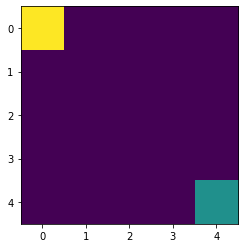

In [87]:
env = GridEnvironment()
obs = env.reset()
env.render()

In [0]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        return np.random.choice(self.action_space.n)
        
    def step(self, observation, verbose=False):
        return self.policy(observation)

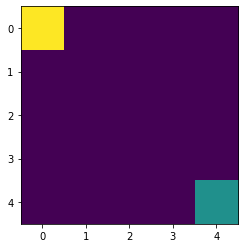

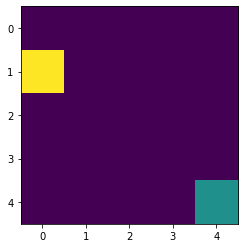

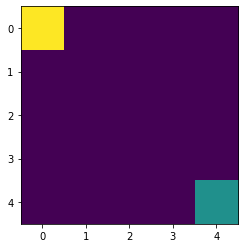

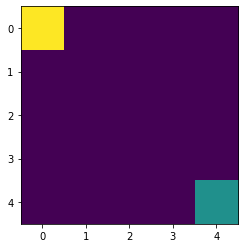

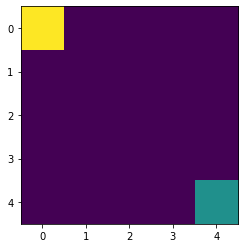

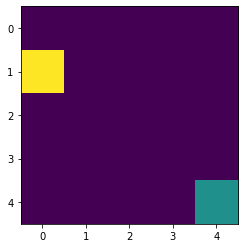

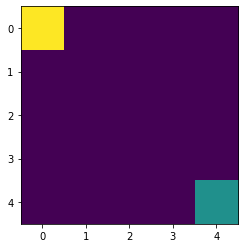

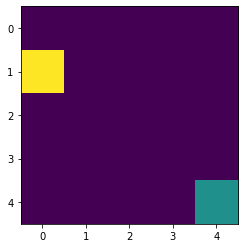

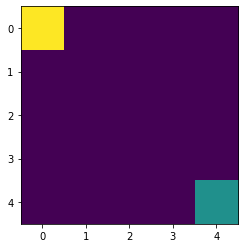

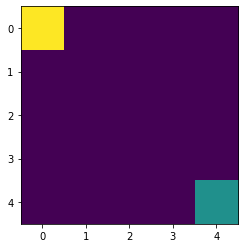

In [89]:
env = GridEnvironment(normalize=True)
agent = RandomAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

In [0]:
class HeuristicAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        # 0 - down
        # 1 - up
        # 2 - right
        # 3 - left
        if (observation[0] < 1.):
            return 0
        if (observation[1] < 1.):
            return 2
        return 0
        
    def step(self, observation, verbose=False):
        if verbose:
            print(observation)
        return self.policy(observation)

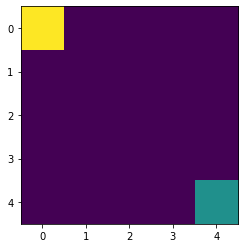

[0. 0.]


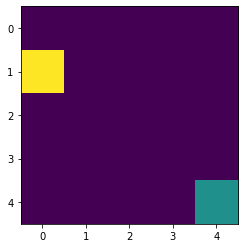

[0.25 0.  ]


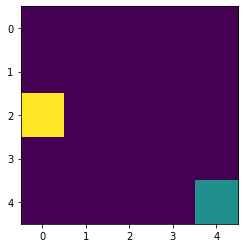

[0.5 0. ]


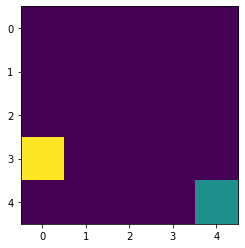

[0.75 0.  ]


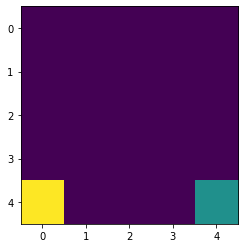

[1. 0.]


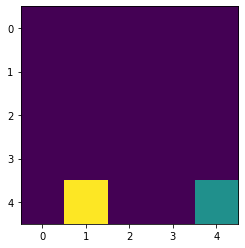

[1.   0.25]


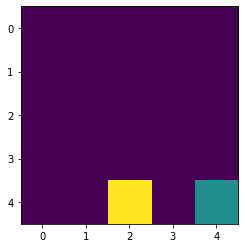

[1.  0.5]


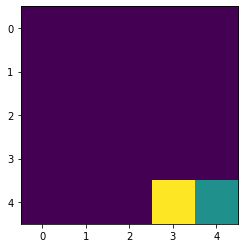

[1.   0.75]


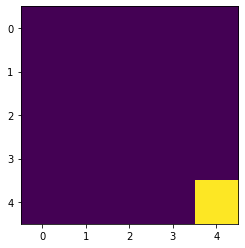

In [91]:
env = GridEnvironment(normalize=True)
agent = HeuristicAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

In [0]:
#proj 4 starts here

class QLearningAgent:
    def __init__(self, env, epsilon=1.0, lr=0.01, gamma=0.9):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        q_table_dim = env.observation_space.shape[0] + 1
        self.q_table = np.zeros((q_table_dim, q_table_dim, env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

    def policy(self, observation):
      exploration_rate_threshold = np.random.uniform(0,1)
      if(exploration_rate_threshold > self.epsilon):
        #agent will exploit the environment and choose the action with the highest value in the q-table for the current state
        return np.argmax(self.q_table[int(observation[0]),int(observation[1])])
      else:
        #agent will explore the environment and sample an action randomnly
        return np.random.choice(self.action_space.n)
      

      # Code for policy (Task 1) (30 points)
        
    def step(self, observation):
        return self.policy(observation)
        
    def update(self, state, action, reward, next_state):
        state = state.astype(int)
        next_state = next_state.astype(int)
        # Code for updating Q Table (Task 2) (20 points)
        self.q_table[state[0],state[1],action]=(self.q_table[state[0],state[1],action]*(1-self.lr))+ self.lr*(reward+self.gamma*np.max(self.q_table[next_state[0],next_state[1]]))
        #obs=next_state
 
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

In [129]:
#and here
import random

env = GridEnvironment() # note: we do not normalize
#agent is the object
agent = QLearningAgent(env)
episodes = 3000 # number of games we want the agent to play
delta_epsilon = agent.epsilon/episodes
total_rewards_sum=0
total_rewards = []
epsilons = [agent.epsilon]
for episode in range(episodes):
  #grid environment = > reset => cleared output
  obs=env.reset()
  #done => when episode is over
  done=False

  epsilons.append(agent.epsilon)
  current_episode_rewards = 0
  while not done:
    #we are copying state in the variable state
    state=obs.copy()
    action=agent.step(obs)
    obs,reward, done, info = env.step(action)
    current_episode_rewards+=reward
    next_state=obs.copy()
    agent.update(state, action, reward, next_state)

  #assume delta_epsilon = 0.1. As the value of episode increases,
  #e=0.1+(1-0.1)e^(-0.1*1)
  exploration_rate = delta_epsilon + (1-delta_epsilon)*np.exp(-delta_epsilon*episode)
  #print(exploration_rate)
  total_rewards.append(current_episode_rewards)
  total_rewards_sum=total_rewards_sum+current_episode_rewards
  agent.set_epsilon(exploration_rate)

print("Q_table:",agent.q_table)



# Training Process (Task 3) (20 points)

Q_table: [[[ 4.25823323e+00  3.03109279e+00  4.94717639e+00  3.05536596e+00]
  [ 4.46513852e+00  2.44688077e+00  2.89869261e+00  2.96252706e+00]
  [ 1.58678808e+00  1.41465231e-01  2.58480341e+00  1.16603626e+00]
  [ 2.29419957e+00 -7.90505133e-02  7.72341858e-01  1.62064143e-01]
  [ 8.51033274e-01 -1.60529605e-01 -1.66816885e-01 -8.50143080e-02]]

 [[ 2.07287310e+00  2.04035774e+00  4.15545345e+00  1.49822913e+00]
  [ 3.95041122e+00  2.29096067e+00  2.69132559e+00  2.16604782e+00]
  [ 1.29969263e+00  2.12597314e-01  2.31827012e+00  5.79590544e-01]
  [ 1.01649044e+00  1.61445009e-01  1.97769885e+00  2.15457415e-01]
  [ 1.47091560e+00 -2.74935082e-01 -1.78499588e-01  2.19822476e-02]]

 [[ 2.03708259e+00  6.66085627e-01  1.62625350e+00 -8.36783807e-03]
  [ 3.38233840e+00  1.60600275e+00  2.02759753e+00  3.99057472e-01]
  [ 1.07302560e+00  1.00122939e-01  1.78768068e+00  2.22270380e-01]
  [ 1.42204734e+00 -7.39913548e-03  4.96622593e-01 -9.58393102e-02]
  [ 9.84780921e-01 -1.16334397e-01 

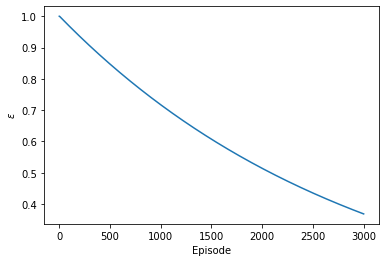

In [130]:
plt.xlabel('Episode')
plt.ylabel('$\epsilon$')
plt.plot(epsilons)

Total rewards:  9324


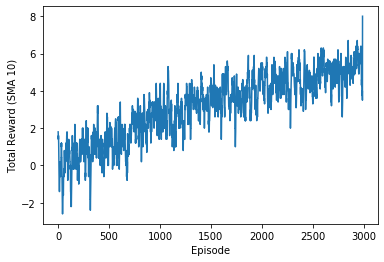

In [131]:
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])
print("Total rewards: ",total_rewards_sum)

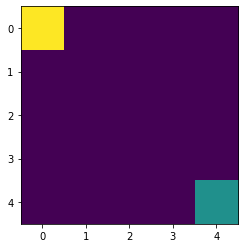

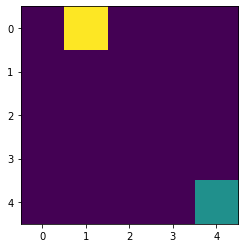

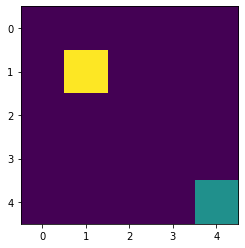

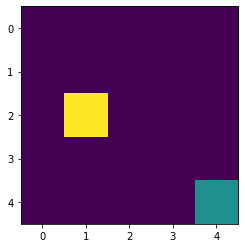

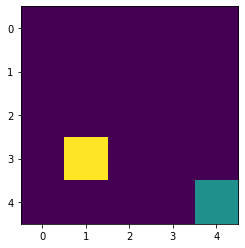

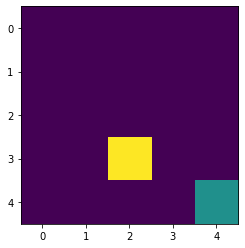

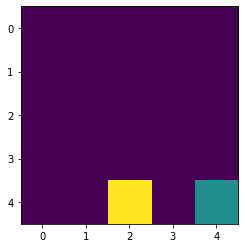

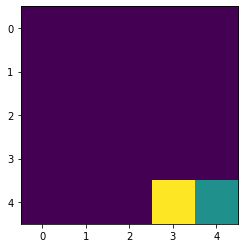

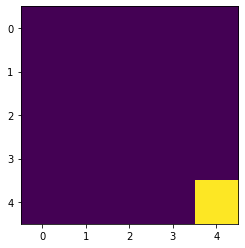

In [132]:
env = GridEnvironment()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()